# Reconstruction of the characteristics and weighting factors of two distributions combined in one measurement series

In [1]:
import numpy as np
from multimodalfit import build_pdf, indicators, plot_pdf, generate_bimodal, rng_lognormal, rng_gamma, estimation_step, fraction_estimator, calc_combined_approximation, dist_lognormal, dist_gamma, estimate_lognormal_mean, estimate_gamma_mean

#### Functions to generate pseudo random numbers according to specified characteristics and then estimate the characteristics again from the pseudo random number histogram

In [2]:
def process(mean1: float, sd1: float, n1: int, mean2: float, sd2: float, n2: int, rng_distribution: callable, estimate_mean: callable, fit_distribution: callable, show_results: bool=True) -> tuple[np.ndarray, np.ndarray]:
    """Generates pseudo random numbers, builds a multimodal histogram and then reconstructs from this histogram the characteristics of the two distributions.

    Args:
        mean1 (float): Mean of the first distribution
        sd1 (float): Standard deviation of the first distribution
        n1 (int): Number of pseudo random numbers to be added to the histogram according to the first distribution
        mean2 (float): Mean of the second distribution
        sd2 (float): Standard deviation of the second distribution
        n2 (int): Number of pseudo random numbers to be added to the histogram according to the second distribution
        rng_distribution (callable): Pseudo random number generator type to be used
        estimate_mean (callable): Function for estimating the mean value from mode and standard deviation
        fit_distribution (callable): Function for getting a frozen distribution object from given mean and standard deviation
        show_results (bool): Print out (text and diagrams) the results of the approximation process? Defaults to True.

    Returns:
        tuple[np.ndarray, np.ndarray]: Histogram of pseudo random numbers of two distributions and approximation
    """

    # Generates a histogram containing pseudo random numbers of two distributions
    max_x = 5_000
    histogram = generate_bimodal(mean1, sd1, n1, mean2, sd2, n2, max_x, rng=rng_distribution, show_info=True)

    # General setup for the estimator
    setup={
        "estimate_mean": estimate_mean,
        "fit_distribution": fit_distribution,
        "show_info": True
    }

    # Estimating the characteristics of the fist distribution contained in the histogram
    print("1. distribution:", end=" ")
    parameters1, residuum1 = estimation_step(histogram, **setup, is_first_step=True)
    f1=n1 / (n1 + n2)
    print("Nominal values: mean=", mean1, ", sd=", sd1, ", fraction=", round(f1 * 100), "%", sep="")

    # Estimating the characteristics of the second distribution contained in the histogram
    print("2. distribution:", end=" ")
    parameters2, _ = estimation_step(residuum1, **setup, fraction_all=1-f1)
    print("Nominal values: mean=", mean2, ", sd=", sd2, ", fraction=",round((1-f1)*100,1),"%", sep="")

    # Optimization of the fractions of the two distributions (is only validly possible after both distributions have been determined)
    fraction1, _ = fraction_estimator(histogram, fit_distribution, parameters1, parameters2)
    parameters1['fraction'], parameters2['fraction'] = fraction1, 1
    print("Post-optimized fractions: ", round(parameters1['fraction'] * 100, 1), "%, ", round((1-parameters1['fraction'])*parameters2['fraction'] * 100, 1), "%", sep="")

    # Build total approximation
    pdf1=build_pdf(max_x, fit_distribution, parameters1["mean"], parameters1["sd"])
    pdf2=build_pdf(max_x, fit_distribution, parameters2["mean"], parameters2["sd"])
    approximation = calc_combined_approximation([{"pdf": pdf1, "fraction": parameters1["fraction"]}, {"pdf": pdf2, "fraction": parameters2["fraction"]}])

    if show_results:
        print("")
        print("Approximation:", end=" ")
        indicators(approximation, show_info=True)
        print("Measured values:", end=" ")
        indicators(histogram, show_info=True)

        plot_pdf(histogram, approximation, 250)

    return histogram, approximation

## Random numbers: log-normal distribution, fit: log-normal distribution

#### **Test 1** (Easy to estimate characteristics)

Measurement series generated in 1.5 seconds.
1. distribution: mean=49.8, sd=104.0, fraction=71%
Nominal values: mean=50, sd=100, fraction=75%
2. distribution: mean=162.8, sd=91.4, fraction=26%
Nominal values: mean=150, sd=80, fraction=25.0%
Post-optimized fractions: 69.3%, 30.7%

Approximation: mode=4, mean=84.4, sd=110.9
Measured values: mode=4, mean=75.0, sd=104.0


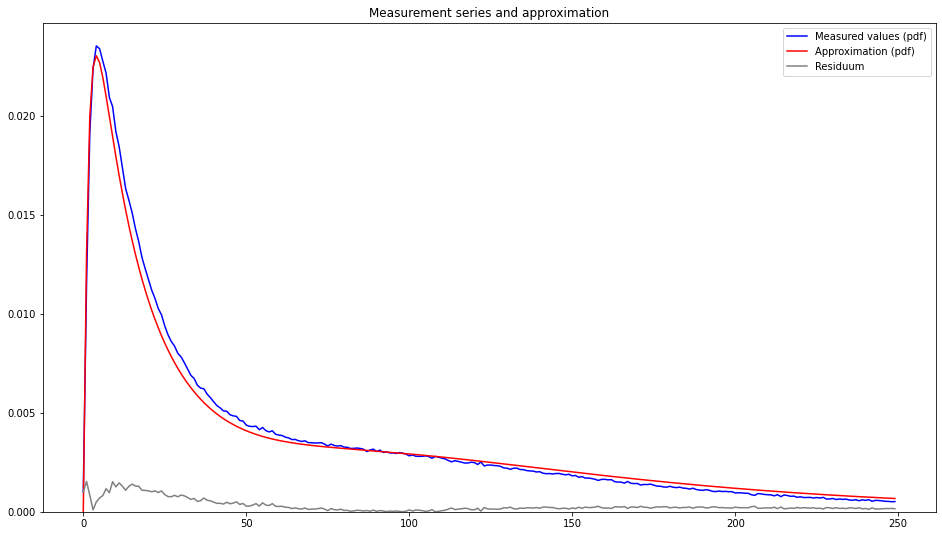

In [3]:
mean1, sd1, n1 = 50, 100, 1_000_000
mean2, sd2, n2 = 150, 80, round(n1 / 3)

histogram, approximation = process(mean1, sd1, n1, mean2, sd2, n2, rng_lognormal, estimate_lognormal_mean, dist_lognormal)

#### **Test 2** (Here, the iterative variance estimator has to intervene already; results are still very good)

Measurement series generated in 1.1 seconds.
1. distribution: mean=50.8, sd=97.6, fraction=79%
Nominal values: mean=50, sd=100, fraction=75%
2. distribution: mean=152.8, sd=30.8, fraction=26%
Nominal values: mean=150, sd=30, fraction=25.0%
Post-optimized fractions: 73.8%, 26.2%

Approximation: mode=5, mean=77.5, sd=94.8
Measured values: mode=5, mean=75.0, sd=97.6


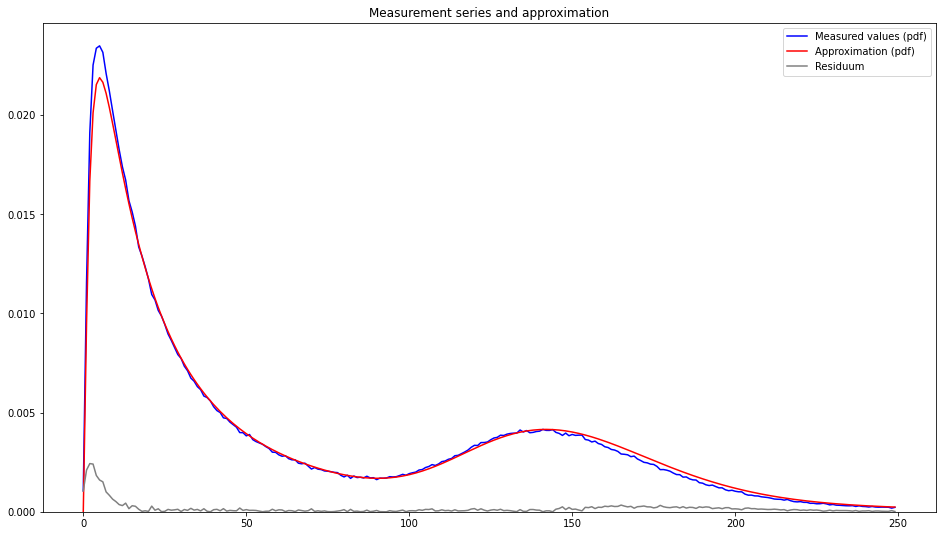

In [4]:
mean1, sd1, n1 = 50, 100, 1_000_000
mean2, sd2, n2 = 150, 30, round(n1 / 3)

histogram, approximation = process(mean1, sd1, n1, mean2, sd2, n2, rng_lognormal, estimate_lognormal_mean, dist_lognormal)

#### **Test 3** (Here it gets difficult)

Measurement series generated in 1.2 seconds.
1. distribution: mean=36.3, sd=14.5, fraction=87%
Nominal values: mean=50, sd=100, fraction=75%
2. distribution: mean=20.3, sd=28.4, fraction=27%
Nominal values: mean=30, sd=5, fraction=25.0%
Post-optimized fractions: 57.9%, 42.1%

Approximation: mode=4, mean=29.5, sd=22.9
Measured values: mode=29, mean=45.0, sd=86.6


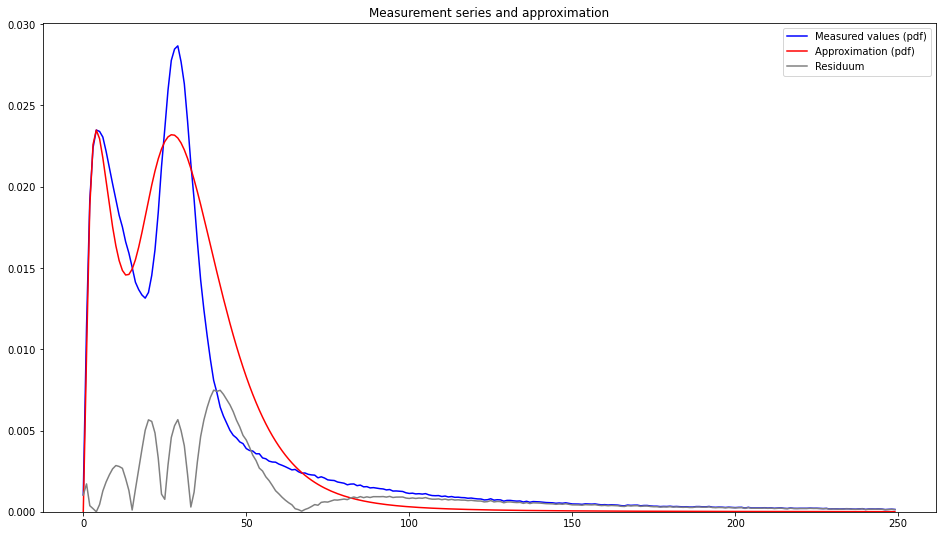

In [5]:
mean1, sd1, n1 = 50, 100, 1_000_000
mean2, sd2, n2 = 30, 5, round(n1 / 3)

histogram, approximation = process(mean1, sd1, n1, mean2, sd2, n2, rng_lognormal, estimate_lognormal_mean, dist_lognormal)

#### **Test 4** (These are realistic values that could be found in a real measurement series)

Measurement series generated in 1.3 seconds.
1. distribution: mean=63.2, sd=42.7, fraction=94%
Nominal values: mean=50, sd=25, fraction=67%
2. distribution: mean=152.0, sd=20.2, fraction=33%
Nominal values: mean=150, sd=25, fraction=33.3%
Post-optimized fractions: 75.6%, 24.4%

Approximation: mode=36, mean=84.9, sd=54.1
Measured values: mode=36, mean=83.3, sd=53.4


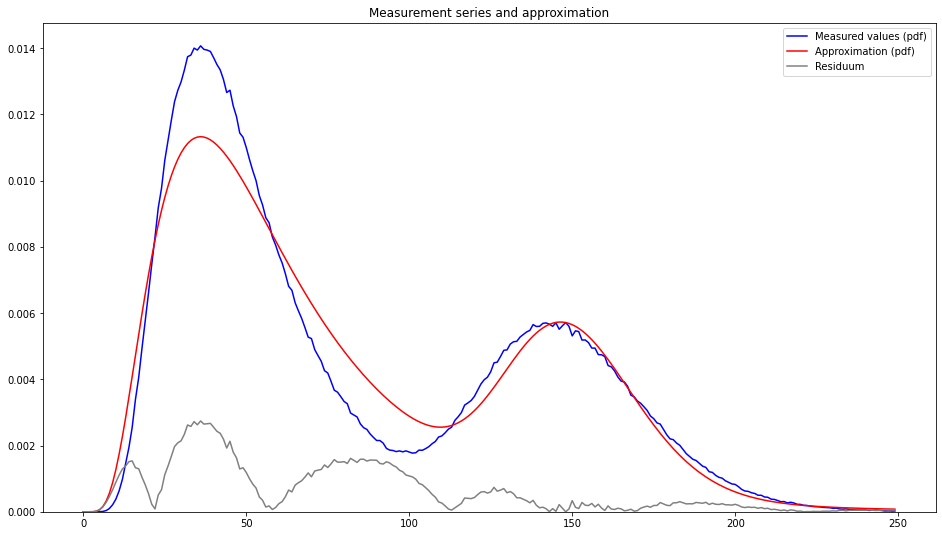

In [6]:
mean1, sd1, n1 = 50, 25, 1_000_000
mean2, sd2, n2 = 150, 25, round(n1 / 2)

histogram, approximation = process(mean1, sd1, n1, mean2, sd2, n2, rng_lognormal, estimate_lognormal_mean, dist_lognormal)

## Random numbers: gamma distribution, fit: gamma distribution

#### **Test 1** (The gamma fit does not work for CV&ge;1)

Measurement series generated in 1.2 seconds.
1. distribution: mean=75.0, sd=105.1, fraction=0%
Nominal values: mean=50, sd=100, fraction=75%
2. distribution: mean=87.2, sd=71.2, fraction=25%
Nominal values: mean=150, sd=80, fraction=25.0%
Post-optimized fractions: 100.0%, 0.0%

Approximation: mode=0, mean=14.8, sd=55.4
Measured values: mode=0, mean=75.0, sd=105.1


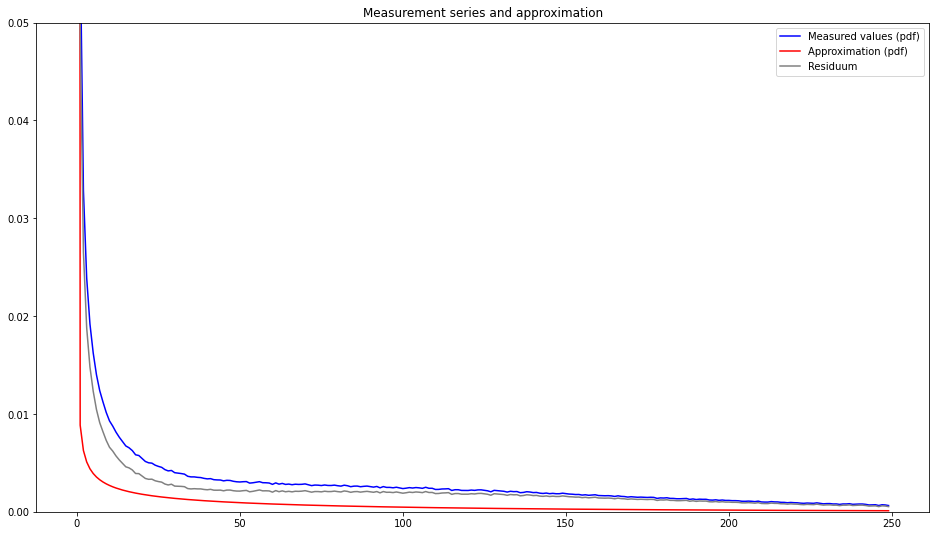

In [7]:
mean1, sd1, n1 = 50, 100, 1_000_000
mean2, sd2, n2 = 150, 80, round(n1 / 3)

histogram, approximation = process(mean1, sd1, n1, mean2, sd2, n2, rng_gamma, estimate_gamma_mean, dist_gamma)

#### **Test 2** (This is equivalent to test 4 for the log-normal distribution; the results here are similarly good)

Measurement series generated in 1.7 seconds.
1. distribution: mean=59.6, sd=34.2, fraction=87%
Nominal values: mean=50, sd=25, fraction=67%
2. distribution: mean=151.4, sd=22.6, fraction=35%
Nominal values: mean=150, sd=25, fraction=33.3%
Post-optimized fractions: 72.0%, 28.0%

Approximation: mode=40, mean=85.3, sd=51.8
Measured values: mode=40, mean=83.3, sd=53.4


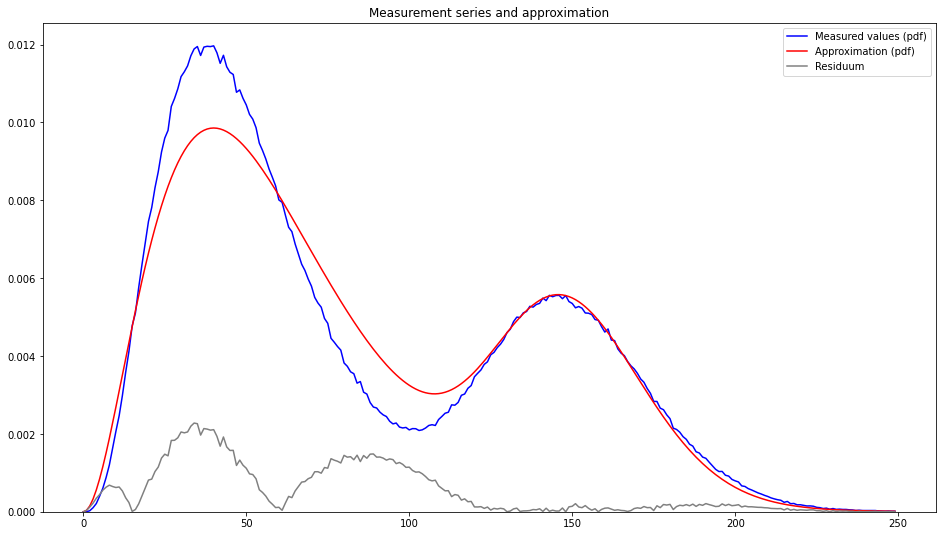

In [8]:
mean1, sd1, n1 = 50, 25, 1_000_000
mean2, sd2, n2 = 150, 25, round(n1 / 2)

histogram, approximation = process(mean1, sd1, n1, mean2, sd2, n2, rng_gamma, estimate_gamma_mean, dist_gamma)

## Random numbers: log-normal distribution, fit: gamma distribution

Measurement series generated in 1.3 seconds.
1. distribution: mean=49.2, sd=27.3, fraction=83%
Nominal values: mean=50, sd=25, fraction=67%
2. distribution: mean=150.9, sd=24.2, fraction=35%
Nominal values: mean=150, sd=25, fraction=33.3%
Post-optimized fractions: 66.6%, 33.4%

Approximation: mode=34, mean=83.2, sd=54.7
Measured values: mode=34, mean=83.3, sd=53.4


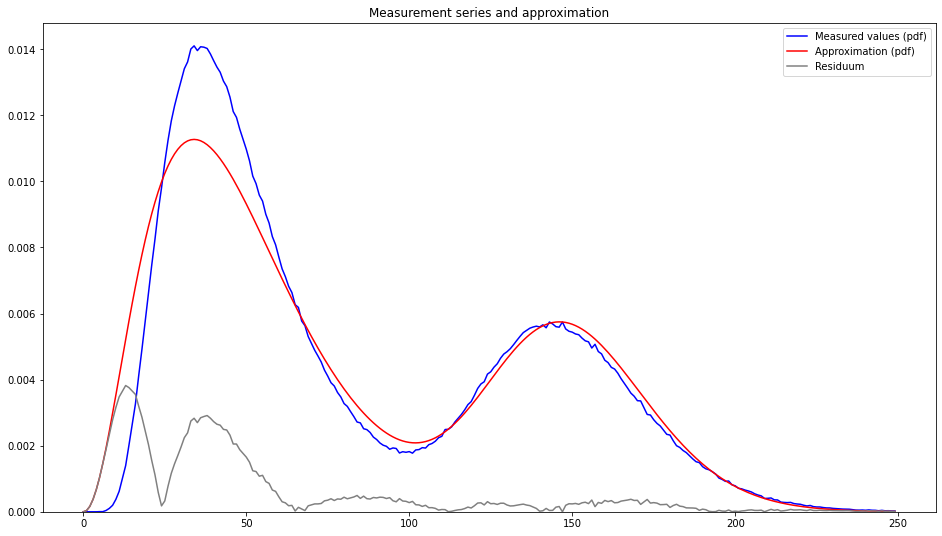

In [9]:
mean1, sd1, n1 = 50, 25, 1_000_000
mean2, sd2, n2 = 150, 25, round(n1 / 2)

histogram, approximation = process(mean1, sd1, n1, mean2, sd2, n2, rng_lognormal, estimate_gamma_mean, dist_gamma)

## Random numbers: gamma distribution, fit: log-normal distribution

Measurement series generated in 1.7 seconds.
1. distribution: mean=70.8, sd=53.4, fraction=92%
Nominal values: mean=50, sd=25, fraction=67%
2. distribution: mean=149.2, sd=18.1, fraction=30%
Nominal values: mean=150, sd=25, fraction=33.3%
Post-optimized fractions: 80.3%, 19.7%

Approximation: mode=36, mean=86.2, sd=57.7
Measured values: mode=36, mean=83.3, sd=53.4


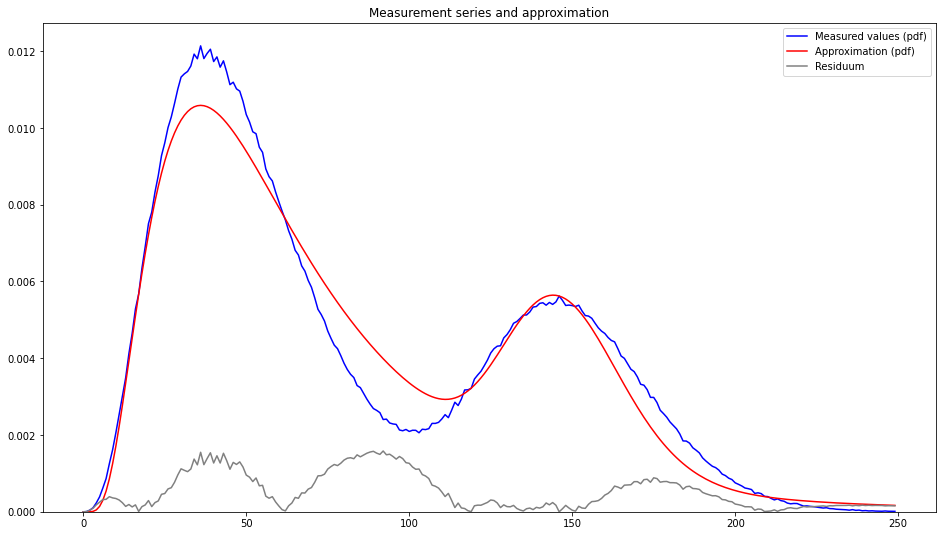

In [10]:
mean1, sd1, n1 = 50, 25, 1_000_000
mean2, sd2, n2 = 150, 25, round(n1 / 2)

histogram, approximation = process(mean1, sd1, n1, mean2, sd2, n2, rng_gamma, estimate_lognormal_mean, dist_lognormal)